## TST analysis

In [1]:
!pip install pytool

In [2]:

#General modules including data restructuring and machine learning libraries
import pandas as pd
import pickle
import pytz
import pytool
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import math
import itertools
from pulp import *
from scipy import stats
from scipy import interpolate
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
from collections import OrderedDict
%matplotlib inline

# System modules
import inspect
import sys
import operator
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def Label_generator(list_length):
    
    Time_labels = []
    
    for t in range(list_length):
        Time_labels+=["T"+str(t+1).zfill(2)]
    
    return Time_labels

In [4]:
def Event_label_generator(list_length):
    
    Event_labels = []
    
    for e in range(list_length*16):
        Event_labels+=["E"+str(e+1).zfill(2)]
    
    return Event_labels

In [5]:
def Timestamp_label_generator(start_date,end_date, tz):
    '''
    Creates and returns a dataframe of timestamps and time_lables T[i]
    '''
    Timestamps = pd.date_range(start_date,end_date,freq = '15T', tz = tz).tolist()
    #del Timestamps[-1]
    
    Time_labels = Label_generator(len(Timestamps))
    
    return pd.DataFrame(OrderedDict((('Time_label',Time_labels),('Timestamp',Timestamps))))

In [6]:
def Holidays_generator():
    
    Holidays = USFederalHolidayCalendar().holidays(start = datetime.date(2018, 1, 1),
                                               end = datetime.date(2018, 12, 31))[[0, 2, 3, 4, 5, 7, 8, 9]]
    
    return Holidays

In [7]:
def Season(dt):
    # Takes in a datetime object and returns the season as outlined by the PG&E E19 plan
    
    if dt.month >= 6 and dt.month <= 10: # if the day is between May 1 and October 31
        return 'Summer' # Mark the day as summer
    else:
        return 'Winter'

In [8]:
def Period(dt, Holidays):
    # Takes in a datetime object (with year, month, day, hour, and minute), the season function, and the Holidays pandas index  
    
    # returns the time period as either Peak, Mid-Peak, or Off-Peak
    
    if Season(dt) == 'Summer': # if the month is during the summer
        
        if (datetime.date(dt.year, dt.month, dt.day) in Holidays) or (dt.isoweekday() >= 6):# If the date is a holiday, it's off-peak
            
            if (datetime.time(hour =  dt.hour) >= datetime.time(hour = 16) and 
                datetime.time(hour =  dt.hour) < datetime.time(hour = 21)):
                
                return 'On-Peak Summer'
        
            elif (datetime.time(hour =  dt.hour) < datetime.time(hour = 14)):
            # If the time is between [2130, 0830) and the day is not a weekend or holiday, it's off-peak
                return 'Super Off-Peak Summer'
        
            else:
                return 'Off-Peak Summer'
        
        else: 
            if (datetime.time(hour =  dt.hour) >= datetime.time(hour = 16) and 
                datetime.time(hour =  dt.hour) < datetime.time(hour = 21)):
                return 'On-Peak Summer' 
        
            elif (datetime.time(hour =  dt.hour) < datetime.time(hour = 6)):
            # If the time is between [2130, 0830) and the day is not a weekend or holiday, it's off-peak
                return 'Super Off-Peak Summer'
        
            else:
                return 'Off-Peak Summer'
    
    # TO DO - Implememt new sdge tariff for winter months
    elif Season(dt) == 'Winter': # if the month is during the winter
        
        if (datetime.date(dt.year, dt.month, dt.day) in Holidays) or (dt.isoweekday() >= 6):# If the date is a holiday, it's off-peak
            
            if (datetime.time(hour =  dt.hour) >= datetime.time(hour = 16) and 
                datetime.time(hour =  dt.hour) < datetime.time(hour = 21)):
                
                return 'On-Peak Winter'
        
            elif (datetime.time(hour =  dt.hour) < datetime.time(hour = 14)):
            # If the time is between [2130, 0830) and the day is not a weekend or holiday, it's off-peak
                return 'Super Off-Peak Winter'
        
            else:
                return 'Off-Peak Winter'
        
        else: 
            if (datetime.time(hour =  dt.hour) >= datetime.time(hour = 16) and 
                datetime.time(hour =  dt.hour) < datetime.time(hour = 21)):
                return 'On-Peak Winter' 
        
            elif (datetime.time(hour =  dt.hour) < datetime.time(hour = 6)):
            # If the time is between [2130, 0830) and the day is not a weekend or holiday, it's off-peak
                return 'Super Off-Peak Winter'
            
            elif (dt.month in [3,4]) & (datetime.time(hour =  dt.hour) >= datetime.time(hour = 10) and 
                datetime.time(hour =  dt.hour) < datetime.time(hour = 14)):
                
                return 'Super Off-Peak Winter'
            
            else:
                return 'Off-Peak Winter'    
        
        
    else:
        return 'Error!'
              

In [9]:
def Tariff_generator(start_ts, end_ts, timezone):
    
    #Define Energy Tariff
    energy_periods = ['On-Peak Summer','Off-Peak Summer','Super Off-Peak Summer', 'On-Peak Winter','Off-Peak Winter','Super Off-Peak Winter']
    energy_rates = [0.140515, 0.119485, 0.098385, 0.125915, 0.113465, 0.099645]
    energy_tariff = dict(zip(energy_periods,energy_rates))
    
    #Generate Holiday schedule
    Holidays =  Holidays_generator()
    tariff_list = []
    
    #Generate time labels and datetime range
    data = Timestamp_label_generator(start_ts,end_ts, timezone)
    
    #Loop through each datetime and assign a tariff according to its season, time conditional on whether its a weekend or holiday
    for ts in data.Timestamp:
        period =  Period(ts,Holidays)
        tariff_list.append(energy_tariff[period])
    
    data = data.assign(energy_tariff = tariff_list)
    
    return data

In [10]:
def Demand_charges_generator():
    
    demand_periods = ['Maximum Peak Demand Summer', 'Maximum Demand Summer',
                      'Maximum Peak Demand Winter', 'Maximum Demand Winter']
    
    demand_rates = [17.42,24.23,16.98,21.34]

    return dict(zip(demand_periods,demand_rates))

In [11]:
def Load_generator(data, start_ts, end_ts, timezone):
    
    data = data.copy()
    
    Holidays =  Holidays_generator()
    Load_values = data[['Timestamp','building.baseline.power.kW']]
    
    Timestamp_labels = Timestamp_label_generator(start_ts,end_ts, timezone)

    Max_demands_load = {}
    periods = []
    seasons = []

    Load_table = Timestamp_labels.merge(Load_values, on = 'Timestamp')
    
    Load_table = Load_table.rename(columns = {'building.baseline.power.kW': 'Load_values'})
        
    for ts in Load_table.Timestamp:
        periods.append(Period(ts,Holidays))
        seasons.append(Season(ts))
    
    Load_table = Load_table.assign(Periods = periods)
    Load_table = Load_table.assign(Seasons = seasons)
    
    
    '''
    interp_func = interpolate.interp1d(list(map(lambda d: d.timestamp(),interp_train.Timestamp)), 
                             interp_train.Load_values, kind = 'linear')

    Load_table = Load_table.assign(Load_values = interp_func(list(map(lambda d: d.timestamp(), Load_table.Timestamp))))
    '''
    Group_object = Load_table.groupby(['Seasons','Periods'])['Load_values'].max()
    
    if "Summer" in seasons:
        Max_demands_load['Maximum_Peak_Demand_Summer'] = Group_object['Summer']['On-Peak Summer']
        Max_demands_load['Maximum_Demand_Summer'] = Group_object["Summer"].max()
    
    if "Winter" in seasons:
        Max_demands_load['Maximum_Peak_Demand_Winter'] = Group_object['Winter']['On-Peak Winter']
        Max_demands_load['Maximum_Demand_Winter'] = Group_object["Winter"].max()

    return (Load_table, Max_demands_load)

In [12]:
def CRS_load(data, start_ts, end_ts, time_labels, timezone):
    
    #Creating CRS Load
    Load_values = data[['Timestamp','crs.baseline.power.kW']]
    
    Timestamp_labels = Timestamp_label_generator(start_ts,end_ts, timezone)

    Load_table = Timestamp_labels.merge(Load_values, on = 'Timestamp')
    Load_table = Load_table.rename(columns = {'crs.baseline.power.kW': 'CRS_Load_values'})
    
    '''
    interp_func = interpolate.interp1d(list(map(lambda d: d.timestamp(),interp_train.Timestamp)), 
                             interp_train.CRS_Load_values, kind = 'linear')

    Load_table = Load_table.assign(CRS_Load_values = interp_func(list(map(lambda d: d.timestamp(), Load_table.Timestamp))))
    '''
    Load_table = Load_table.assign(temperature = data.temperature)
    
    return dict(zip(time_labels, Load_table['CRS_Load_values'])), Load_table

In [13]:
def get_Limits(data, MCL, sensible_subcool):
    
    #Convert oat_c from F to C
    df = data.assign(oat_c = data.temperature.apply(lambda d: (d - 32)*5/9))

    # Isentropic efficiency:
    Isentropic_eff = lambda t: -0.0001093*t*t + 0.006782*t + 0.5704
    
    # Max Rack Load fit:
    MRC = lambda t: -0.001532*t*t - 4.87*t + 424.1
    
    # Charge COP fit for RT = 1
    CHG_COP_rt1 = lambda t: -4.341e-5*t*t - 0.0173*t + 1.81
    
    # Calculate Charge limits:
    
    total_rack_capacity = df.oat_c.apply(MRC)
    
    crs_kwth = df.CRS_Load_values*df.oat_c.apply(Isentropic_eff)
    
    remaining_crs_kwth = total_rack_capacity - crs_kwth
    
    chg_limit_kwth = [min(x,MCL) for x in remaining_crs_kwth]
    cop_chg_rt1 = df.oat_c.apply(CHG_COP_rt1)
    
    chg_limit = chg_limit_kwth/cop_chg_rt1

    # ---------------------------------------------------------------------

    # Calculate Discharge limits:
    
    # Sensible subcool fit:
    sens_subcool_func = lambda t:  0.01364*t*t - 0.4733*t + 3.973
    
    subcool_offset = df.oat_c.apply(sens_subcool_func)
    
    if sensible_subcool :
        dchg_limit = data['CRS_Load_values'] + subcool_offset
    else:
        dchg_limit = data['CRS_Load_values']
        
    df['charge_limits'] = chg_limit
    df['discharge_limits'] = dchg_limit
    
    return dict(zip(time_labels, chg_limit)), dict(zip(time_labels, dchg_limit)), df


In [14]:
def get_COPs(data, start_ts, end_ts, time_labels, sens_subcool):

    
    # For RT = 1 (HTF pump power of 3.5kWe at 170 gpm)
    CHG_COP_rt_10 = lambda t: 0.00011286509783997348*t*t -0.02835906022493903*t + 2.0938080794453984
    
    CHG_COP_rt_05 = lambda t: 0.0011778033118712684*t*t -0.15557305693781495*t + 2.235440437544005
    
    COP_chg_func = CHG_COP_rt_10

    if sens_subcool:
        COP_dchg_func = lambda t: 0.001091*t*t - 0.155*t + 6.359
    else:
        COP_dchg_func = lambda t: 0.0011778033118712684*t*t -0.15557305693781495*t + 6.632059210693061
    
    """
    
    if (no_of_tanks==3):
        COP_chg_func = lambda t: -0.0000197*t*t - 0.0259*t + 2.298 # 3 PCES Tanks 19a
    elif (no_of_tanks==4):
        COP_chg_func = lambda t: -0.0000188*t*t - 0.0261*t + 2.308 # 4 PCES Tanks 19b
    elif (no_of_tanks==5):
        COP_chg_func = lambda t: -0.0000184*t*t - 0.02619*t + 2.313 # 5 PCES Tanks 19c
    elif (no_of_tanks==6):
        COP_chg_func = lambda t: -0.0000181*t*t - 0.02624*t + 2.315 # 6 PCES Tanks 19d
    
    #COP_chg_func = lambda t: 0.0001403*t*t - 0.03362*t + 2.346
    #COP_chg_func = lambda t: 0.0002245*t*t - 0.04221*t + 2.69
    """
    
    Timestamp_labels = Timestamp_label_generator(start_ts,end_ts, timezone)
    
    COP_df = Timestamp_labels.merge(data, on= 'Timestamp') 
    
    COP_df = COP_df.assign(oat_c = COP_df.temperature.apply(lambda d: (d - 32)*5/9))

    COP_df = COP_df.assign(COP_dchg = COP_df.oat_c.apply(COP_dchg_func))
    COP_df = COP_df.assign(COP_chg = COP_df.oat_c.apply(COP_chg_func))
    
    Dchg_dict = dict(zip(time_labels,COP_df.COP_dchg))
    Chg_dict = dict(zip(time_labels,COP_df.COP_chg))
    
    return (Dchg_dict,Chg_dict, COP_df.reset_index(drop=True))

In [15]:
def get_event_loads(Load_table, event_days):
    
    event_loads = []
    
    for ts in Load_table.Timestamp:
        if ts.date() in event_days:
            if (datetime.time(hour =  ts.hour) >= datetime.time(hour = 14) and 
                datetime.time(hour =  ts.hour) < datetime.time(hour = 18)):
                event_loads.append(Load_table.loc[Load_table.Timestamp == ts]['Load_values'].iloc[0])
    
    return event_loads

In [16]:
def Bill_calculator(Load, Tariff, Max_demands, cap_res, cap_res_rate, cpp_addr, event_loads, days):

    summer_days = days[0]
    winter_days = days[1]
    total_days = summer_days + winter_days
    
    Demand_charges = Demand_charges_generator()
    
    Energy_bill = sum([a*b/4 for a,b in zip(Load, Tariff)])
    
    if summer_days != 0:
        Demand_bill_summer = (Max_demands['Maximum_Demand_Summer']*Demand_charges['Maximum Demand Summer']+
                          Max_demands['Maximum_Peak_Demand_Summer']*Demand_charges['Maximum Peak Demand Summer'])
    else :
        Demand_bill_summer = 0

    if winter_days != 0:
        Demand_bill_winter = (Max_demands['Maximum_Demand_Winter']*Demand_charges['Maximum Demand Winter']+
                         Max_demands['Maximum_Peak_Demand_Winter']*Demand_charges['Maximum Peak Demand Winter'])
        
    else :
        Demand_bill_winter = 0

    Demand_bill = Demand_bill_summer*summer_days/total_days + Demand_bill_winter*winter_days/total_days
    
    CPP_event_cost = sum([0.25*(load - cap_res)*cpp_addr for load in event_loads])
        
    CPP_fixed = cap_res*cap_res_rate
    
    CPP_bill =  CPP_fixed + CPP_event_cost
    
    return (Energy_bill, Demand_bill, CPP_bill)

In [17]:
def get_heatleak(df):
    
    heat_leak_fit = lambda t : 1.620034306572543e-06*t*t + 0.055326591739501836*t + 1.4352336893428248
    
    df = df.assign(heatleak = df.oat_c.apply(heat_leak_fit))
    
    return dict(zip(time_labels, df.heatleak))

In [18]:
def evaluate(dchg_cop, chg_cop):
    
    SOC = LpVariable.dicts("SOC", time_labels, lowBound = 0, upBound = RB_capacity)

    dof = LpVariable.dicts("Discharge_Offset", time_labels, lowBound = 0 , upBound = None)

    cof = LpVariable.dicts("Charge_Offset", time_labels, lowBound = 0 , upBound = None)

    y = LpVariable.dicts("Selector", time_labels, lowBound = None , upBound = None, cat = 'Binary')

    Max_peak_Summer = LpVariable("Maximum Peak Demand Summer", lowBound = 0, upBound = None)
    Max_Summer = LpVariable("Maximum Demand Summer", lowBound = 0, upBound = None)

    Max_peak_Winter = LpVariable("Maximum Peak Demand Winter", lowBound = 0, upBound = None)
    Max_Winter = LpVariable("Maximum Demand Winter", lowBound = 0, upBound = None)

    E = LpVariable.dict("Event_intervals", event_labels, lowBound=0, upBound= None)
    
    prob = LpProblem("Simple schedule optimization",LpMinimize)

    #### Defining Objective function

    Energy_portion = [Energy_Tariff[t]*(0.25*Building_Power[t] - 0.25*(dof[t] - cof[t])) for t in time_labels]
    Demand_portion = [Max_peak_Summer*Demand_charges['Maximum Peak Demand Summer'] +
                      Max_Summer*Demand_charges['Maximum Demand Summer'] + 
                      Max_peak_Winter*Demand_charges['Maximum Peak Demand Winter'] +
                      Max_Winter*Demand_charges['Maximum Demand Winter']]
    CPP_portion = [E[e]*CPP_adder for e in event_labels]

    prob+=lpSum(Energy_portion + Demand_portion + CPP_portion)


    #### Defining constraints

    count = 0
    event_ts_labels = []

    for t in range(0,len(time_labels)):

        if (t < len(time_labels)-1):
            soc_difference = (SOC[time_labels[t]] - SOC[time_labels[t+1]])

            effective_energy = 0.25 * (dchg_cop[time_labels[t]]*dof[time_labels[t]] - chg_cop[time_labels[t]]*cof[time_labels[t]]) 

            heat_leak_value = 0.25*heat_leak[time_labels[t]]  
                
            prob+= soc_difference == effective_energy + heat_leak_value

        prob+= cof[time_labels[t]] <= chg_limits[time_labels[t]]

        prob+= dof[time_labels[t]] <= dchg_limits[time_labels[t]]

        prob+= dof[time_labels[t]] <= M*y[time_labels[t]]

        prob+= cof[time_labels[t]] <= M*(1-y[time_labels[t]])

        # Adding constraints for event days
        ts = Timestamp_labels[time_labels[t]]

        if ts.date() in event_days:


            if (datetime.time(hour =  ts.hour) >= datetime.time(hour = 14) and 
                datetime.time(hour =  ts.hour) < datetime.time(hour = 18)):

                prob+=  E[event_labels[count]] == 0.25*(Building_Power[time_labels[t]] - dof[time_labels[t]] - Cap_res)
                count+=1

            else:

                event_ts_labels.append(time_labels[t])

        if (Season(ts) == 'Summer'):

            if time_labels[t] not in event_ts_labels: 

                prob+= Max_Summer>= Building_Power[time_labels[t]] - (dof[time_labels[t]] - cof[time_labels[t]])

            if Period(Timestamp_labels[time_labels[t]], Holidays) == 'On-Peak Summer':

                prob+= Max_peak_Summer>= Building_Power[time_labels[t]] - (dof[time_labels[t]] - cof[time_labels[t]])


        else:

            if time_labels[t] not in event_ts_labels:

                prob+= Max_Winter>= Building_Power[time_labels[t]] - (dof[time_labels[t]] - cof[time_labels[t]])

            if Period(Timestamp_labels[time_labels[t]], Holidays) == 'On-Peak Winter':

                prob+= Max_peak_Winter>= Building_Power[time_labels[t]] - (dof[time_labels[t]] - cof[time_labels[t]])


        # Additional bounding constraint on discharge offset as f(SOC)

        fac_decrease = dchg_cop[time_labels[t]]

        for pair in mc_list:
            prob+= dof[time_labels[t]] <= (pair[0]*SOC[time_labels[t]] + pair[1])/fac_decrease


    # Adding constraints for initial & final condition (SOC)

    prob+=SOC["T01"] == SOC_initial
    prob+=SOC[time_labels.iloc[-1]] == SOC_final

    #### Past peak target setting

    """
    if season == "Summer":
        prob+= Max_peak_Summer >= on_peak
        prob+= Max_Summer >= non_coincidental

        prob+= Max_Summer >= Max_peak_Summer

    else:
        prob+= Max_peak_Winter >= on_peak
        prob+= Max_Winter >= non_coincidental

        prob+= Max_Winter >= Max_peak_Winter
    """

    lpFileName= "batteryOperation.lp"
    prob.writeLP(lpFileName)

    LpSolverDefault.msg = 1

    prob.solve()

    ## SEE STATUS OF OPTIMIZATION SOLUTION HERE:

    # print status
    print("Status:", LpStatus[prob.status])

    discharge_offsets = {}
    charge_offsets = {} 
    charge_states = {}
    selector = {}
    Event_interval_excess = {}
    Max_demands_newload = {}

    for v in prob.variables():

        if (v.name[0:9] == 'Discharge'):
            discharge_offsets[v.name] = v.varValue

        elif (v.name[0:6] == 'Charge'):
            charge_offsets[v.name] = v.varValue

        elif(v.name[0:3] == 'SOC'):
            charge_states[v.name] = v.varValue

        elif(v.name[0:8] == 'Selector'):
            selector[v.name] = v.varValue

        elif(v.name[0:5] == "Event"):
            Event_interval_excess[v.name] = v.varValue

        else:
            Max_demands_newload[v.name] = v.varValue

    offset_dchg = []
    offset_chg = []
    offset_values = []
    charge_values = []
    crs_load = []
    Max_charge_values = []
    Max_discharge_values = []
    charge_cop_list = []
    discharge_cop_list = []
    heat_leak_list = []

    for i in range(1,len(time_labels)+1):
        offset_dchg.append(discharge_offsets["Discharge_Offset_T"+str(i).zfill(2)])
        offset_chg.append(-charge_offsets["Charge_Offset_T"+str(i).zfill(2)])         
        offset_values.append(discharge_offsets["Discharge_Offset_T"+str(i).zfill(2)] - charge_offsets["Charge_Offset_T"+str(i).zfill(2)])
        charge_values.append(charge_states["SOC_T"+str(i).zfill(2)])
        crs_load.append(CRS_dict[time_labels[i-1]])
        Max_charge_values.append(-chg_limits[time_labels[i-1]])
        Max_discharge_values.append(dchg_limits[time_labels[i-1]])
        charge_cop_list.append(chg_cop[time_labels[i-1]])
        discharge_cop_list.append(dchg_cop[time_labels[i-1]])
        heat_leak_list.append(heat_leak[time_labels[i-1]])
        

    new_Load_values = [a - b for a,b in zip(Load_values,offset_values)]

    new_Load_table = Load_table.assign(Load_values = new_Load_values)

    # Threshold & Savings Results

    event_loads = get_event_loads(Load_table, event_days)
    new_event_loads = get_event_loads(new_Load_table, event_days)
    
    output = pd.DataFrame({'Timelabels': time_labels,
                          'Discharge_offset':offset_dchg,
                          'Charge_offset':offset_chg,
                          'Offset':offset_values,
                          'Timestamps': Tariff_table.Timestamp,
                          'State_of_charge':charge_values,
                          'Max_charge_limit': Max_charge_values, 
                          'Max_discharge_limit': Max_discharge_values,
                          'Baseline': Load_values,
                          'Target': new_Load_values,
                          'Temperature' : COP_df.temperature,
                          'COP_discharge':discharge_cop_list,
                          'COP_charge': charge_cop_list,
                          'CRS_load' : crs_load,
                          'Heat_leak': heat_leak_list
                         })
    
    [old_energybill, old_demandbill, old_cpp_bill] = Bill_calculator(Load_values, Tariff_list, Max_demands_load, 
                                                       Cap_res, Cap_res_rate, CPP_adder, event_loads, day_split)
    [new_energybill, new_demandbill, new_cpp_bil] = Bill_calculator(new_Load_values, Tariff_list,Max_demands_newload,
                                                       Cap_res, Cap_res_rate, CPP_adder, new_event_loads, day_split)
    
    # Adding Reactive Control Buffer
    
    Max_demands_adj = {k:v + RCB for k,v in Max_demands_newload.items()}
    
    [adj_energybill, adj_demandbill, adj_cpp_bil] = Bill_calculator(new_Load_values, Tariff_list,Max_demands_adj,
                                                       Cap_res, Cap_res_rate, CPP_adder, new_event_loads, day_split) 

    print("Building baseline demand peaks are: \n", Max_demands_load)

    print("Target demand peaks are: \n", Max_demands_newload)

    demand_savings = old_demandbill - adj_demandbill
    energy_savings = old_energybill - new_energybill
    cpp_savings = old_cpp_bill - new_cpp_bil
    total_savings = demand_savings + energy_savings + cpp_savings
    
    print("Ideal Demand Savings  ${}".format(demand_savings))
    print("Ideal Energy Savings  ${}".format(energy_savings))
    print("Ideal CPP Savings     ${}".format(cpp_savings))
    print("Ideal Total Savings   ${}".format(total_savings))

    return output, demand_savings, energy_savings, cpp_savings, total_savings

In [19]:
def line(p1, p2):
    x1, y1 = p1
    x2, y2 = p2

    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return lambda x: m*x + b

In [20]:
def get_updated_cop(df):
    
    CHG_COP_rt_10 = lambda t: 0.00011286509783997348*t*t -0.02835906022493903*t + 2.0938080794453984
    
    CHG_COP_rt_05 = lambda t: 0.0011778033118712684*t*t -0.15557305693781495*t + 2.235440437544005
    
    df = df.assign(temperature = df.Temperature.apply(lambda d: (d - 32)*5/9))
    
    chg_offset_kwth = -df.Charge_offset * df.COP_charge
    
    # Get interpolated RT from charge offset kwth
    min_rt = 0.5/3
    max_rt = 1.0
    
    rt_line = line((SI_MCL_lower, min_rt),(SI_MCL_upper, max_rt))
    rt = rt_line(chg_offset_kwth)
    
    rt.loc[rt<min_rt]=min_rt
    
    # Get interpolated CHG COP
    min_cops = df.temperature.apply(CHG_COP_rt_05)
    max_cops = df.temperature.apply(CHG_COP_rt_10)
    
    cop_lines = line((min_rt, min_cops),(max_rt, max_cops))
    
    chg_cop = cop_lines(rt)
    
    return dict(zip(time_labels, chg_cop))

# Main Code

### Instructions: Give path to perfest & weather files below

In [21]:
load_data_file = "2018_11_01_to_2019_06_02_perfest.pickle" #WMEC_2017_baselines_March_Oct       2018_11_01_to_2019_06_02_perfest
temperature_data_file = "2018_11_01_to_2019_06_02_weather.pickle"#WMEC_2017_temperature_March_Oct     2018_11_01_to_2019_06_02_weather

In [22]:
with open(load_data_file, 'rb') as fp:
    perf_data = pickle.load(fp)
    
with open(temperature_data_file, 'rb') as tp:
    temp_data = pickle.load(tp)

In [23]:
USPAC = pytz.timezone('US/Pacific')

In [24]:
if isinstance(perf_data, dict) & isinstance(temp_data, dict):
    
    perf_df = pd.DataFrame(perf_data['values'], columns = perf_data['columns'])
    perf_df.time = perf_df.time.apply(lambda d: pytool.time.fromutctimestamp(d/1000000))
    perf_df.time = perf_df.time.apply(lambda d: d.astimezone(USPAC))
    perf_df = perf_df.set_index('time', drop=True)
    perf_df = perf_df.resample('15T').mean()
    
    tdf = pd.DataFrame(temp_data['values'], columns =  temp_data['columns'])
    tdf.time = tdf.time.apply(lambda d: pytool.time.fromutctimestamp(d/1000000))
    tdf.time = tdf.time.apply(lambda d: d.astimezone(USPAC))
    tdf = tdf.set_index('time', drop=True)
    tdf = tdf.resample('15T').mean()
    
else:
    perf_df = perf_data
    perf_df.time = perf_df.time.apply(lambda d: USPAC.localize(d))
    perf_df = perf_df.set_index('time', drop=True)
    tdf = temp_data
    tdf.time = tdf.time.apply(lambda d: USPAC.localize(d))
    tdf = tdf.set_index('time', drop=True)

In [25]:
perf_df = perf_df.assign(Timestamp = perf_df.index)
tdf = tdf.assign(Timestamp = tdf.index)

In [26]:
perf_df = perf_df.reset_index(drop=True)
tdf = tdf.reset_index(drop=True)

In [27]:
tdf = tdf[['temperature','Timestamp']]

In [28]:
#tdf.head(5)
#perf_df.head(5)

In [29]:
len(perf_df)

20543

In [30]:
len(tdf)

20543

### Set RB CAPACITY & SLOPE-INTERCEPT VALUES HERE: 

In [31]:
#Configuration for - 20
#configuration = {3:(1300,[(1.274433,2.959688),(0.336134,36.103594),(0.179726,72.055120),(0.043531,129.503864),(0.080557,86.631784)]),
               #  4:(1994,[(6.661962,1.140559),(0.680812,20.741421),(0.287804,46.541683),(0.141617,91.239041),(0.030589,158.985901),(0.679740,-1078.868280)]),
                # 5:(2475,[(0.884465,7.121315),(0.282327,48.687316),(0.142177,93.556521),(0.079878,130.156775),(0.020400,182.391462),(0.524228,-1019.933002)]), 
                 #6:(2955,[(1.031328,8.097714),(0.276624,53.611903),(0.135329,98.482125),(0.068889,140.393125),(0.015271,198.184738),(0.542011,-1313.734919)])}
#This is the update configuration for 3,4, and 5 tanks. We might have to remove the last term that is being linearized since this might create an over constrain in the problem

configuration = {3:(1391,[(20.798406,6.510438),(1.179376,30.423908),(0.151886,97.356370),(0.038226,138.415064),(0.116077,47.640328)]),
                 4:(1854,[(29.831810,7.345354),(0.390607,55.583742),(0.164344,101.413539),(0.025810,170.186787),(0.102405,44.464230)]),
                5:(2319,[(118.574931,7.184441),(1.585666,43.248301),(0.075239,118.931145),(0.165486,101.703185),(0.021718,186.597549)]), 
                 }

## SET NO OF TANKS HERE:

In [32]:
no_of_tanks = 5

## Set Start & End date & other optimization parameters here:

In [33]:
# define start and end periods
start_date = pd.to_datetime('2018-12-1 00:00:00')
end_date = pd.to_datetime('2018-12-31 23:45:00')#14:45:00 23:45
timezone = USPAC
#define tuning parameters value

SI_MCL_upper = 91.61            # CMP RT 1.0 in kWt 91.61 wmec specific
SI_MCL_lower = 18.32            # CMP RT 0.5/3 kWt 18.32
MDCR =  1000                     # Max discharge rate
SOC_initial = 1855           # Initial state of charge
SOC_final = SOC_initial
RB_capacity = configuration[no_of_tanks][0]            # Thermal Tank
M = 10000                       # Large M value for using big M method
billing_window = 30
sensible_subcool = True
RCB = 0                        #Reactive Control Buffer; 0 means no reactive control buffer
derating_factor_energy = 0.95      # Derating factor for energy (read as "derate to") : 1 means no derating
derating_factor_demand = 0.85      # Derating factor for demand (read as "derate to") : 1 means no derating

### CPP related configuration parameters

Cap_res = 163.9        # in KW don't really need to change since it has been set with SDG&E part of the CPP rate plan
CPP_adder = 1.88        # in $/kWh set according to tariff document
Cap_res_rate = 4.68    # in $/kW per month set according to tariff document WMEC specific
event_days = [datetime.date(2017, 8, 6),#8 Sep
              datetime.date(2017, 8, 7),#9 Sep
              datetime.date(2017, 8, 9)]#14 Sep
               # datetime.date(2018, 9, 13),#14 Sep
              # datetime.date(2018, 9, 27)
             #]
event_days = []        # no CPP turn on and off

In [34]:
event_labels = Event_label_generator(len(event_days))
mc_list = configuration[no_of_tanks][1]
no_of_days = (end_date - start_date).days
Holidays = Holidays_generator()
tf = no_of_days/billing_window

tsdf = Timestamp_label_generator(start_date,end_date, timezone)

In [35]:
mid_df = tsdf.merge(tdf, on  ='Timestamp')

In [36]:
final_df = mid_df.merge(perf_df, on = 'Timestamp')

In [37]:
final_df.index = final_df.Timestamp
#final_df = final_df.interpolate(method = 'bfill')
final_df = final_df.fillna(method = 'bfill')

final_df = final_df[~final_df.duplicated(subset = 'Timestamp', keep = 'first')]
final_df = final_df.reset_index(drop=True)

In [38]:
#### ADD TEMPERATURE FLOOR
final_df.temperature = final_df.temperature.apply(lambda d: 57 if d<57 else d)

In [39]:
final_df[final_df["crs.baseline.power.kW"].isnull()]

,Time_label,Timestamp,temperature,building.actual.power.kW,building.baseline.power.kW,building.offset.kW,crs.baseline.power.kW,crs.offset.rackA.power.kW,crs.offset.rackB.power.kW,rb.state_of_charge.fraction,rb.state_of_charge.percent,rbCur_num


In [40]:
# final_df.columns
Demand_charges = Demand_charges_generator()
[Load_table,Max_demands_load] = Load_generator(final_df,start_date,end_date, timezone)

In [41]:
Summer_days = len(Load_table[Load_table.Seasons == 'Summer']) if "Summer" in list(Load_table.Seasons) else 0
Winter_days = len(Load_table[Load_table.Seasons == 'Winter']) if "Winter" in list(Load_table.Seasons) else 0
day_split = (Summer_days, Winter_days)

In [42]:
#### Update start & end dates based on available data in the Load table
start_date = Load_table.Timestamp.iloc[0]
end_date = Load_table.Timestamp.iloc[-1]
Tariff_table = Tariff_generator(start_date, end_date, timezone)

In [43]:
Energy_Tariff = dict(zip(Tariff_table.Time_label,Tariff_table.energy_tariff))
Building_Power = dict(zip(Load_table.Time_label,Load_table.Load_values))

Load_values = Load_table.Load_values
Tariff_list = Tariff_table.energy_tariff

Timestamp_labels = dict(zip(Tariff_table.Time_label,Tariff_table.Timestamp))

time_labels = Tariff_table.Time_label

In [44]:
CRS_dict, CRS_Load = CRS_load(final_df, start_date, end_date, time_labels, timezone)

[dchg_cop, chg_cop, COP_df] = get_COPs(final_df, start_date, end_date, time_labels, sensible_subcool)

chg_limits, dchg_limits, limits_df = get_Limits(CRS_Load, SI_MCL_upper, sensible_subcool)

heat_leak = get_heatleak(COP_df)

## MAIN ITERATIVE LOOP

In [45]:
previous_total_savings = 0
prev_diff = 0
count = 1

while True:

    output, demand_savings, energy_savings, cpp_savings, total_savings = evaluate(dchg_cop, chg_cop)
    
    diff = abs(previous_total_savings - total_savings)
    
    if diff < 10 or count == 5 or abs(diff - prev_diff) < 1:
        break
    
    
    previous_total_savings = total_savings
    prev_diff = diff
    chg_cop = get_updated_cop(output)
    
    count+= 1

Status: Optimal
Building baseline demand peaks are: 
 {'Maximum_Peak_Demand_Winter': 221.44716383333332, 'Maximum_Demand_Winter': 221.44716383333332}
Target demand peaks are: 
 {'Maximum_Demand_Summer': 0.0, 'Maximum_Demand_Winter': 183.27743, 'Maximum_Peak_Demand_Summer': 0.0, 'Maximum_Peak_Demand_Winter': 181.86769}
Ideal Demand Savings  $1486.6015856933327
Ideal Energy Savings  $-347.5978846717371
Ideal CPP Savings     $0.0
Ideal Total Savings   $1139.0037010215956
Status: Optimal
Building baseline demand peaks are: 
 {'Maximum_Peak_Demand_Winter': 221.44716383333332, 'Maximum_Demand_Winter': 221.44716383333332}
Target demand peaks are: 
 {'Maximum_Demand_Summer': 0.0, 'Maximum_Demand_Winter': 185.05083, 'Maximum_Peak_Demand_Summer': 0.0, 'Maximum_Peak_Demand_Winter': 183.87868}
Ideal Demand Savings  $1414.6106194933327
Ideal Energy Savings  $-299.0954589681987
Ideal CPP Savings     $0.0
Ideal Total Savings   $1115.515160525134
Status: Optimal
Building baseline demand peaks are: 
 {

In [46]:
print("Ideal Demand Savings  ${}".format(demand_savings))
print("Ideal Energy Savings  ${}".format(energy_savings))
print("Ideal CPP Savings     ${}".format(cpp_savings))
print("Ideal Total Savings   ${}".format(demand_savings + energy_savings + cpp_savings))
print(diff)

Ideal Demand Savings  $1412.6732080933325
Ideal Energy Savings  $-175.98558325806516
Ideal CPP Savings     $0.0
Ideal Total Savings   $1236.6876248352673
48.74205592843737


In [47]:
# Derated savings (Will be the same as Ideal savings if derating factors are set to 1)
print("Derated Demand Savings  ${}".format(demand_savings*derating_factor_demand))
print("Ideal Energy Savings  ${}".format(energy_savings*derating_factor_energy))
print("Ideal CPP Savings     ${}".format(cpp_savings))
print("Ideal Total Savings   ${}".format(demand_savings*derating_factor_demand + 
                                         energy_savings*derating_factor_energy + 
                                         cpp_savings))

Derated Demand Savings  $1200.7722268793325
Ideal Energy Savings  $-167.1863040951619
Ideal CPP Savings     $0.0
Ideal Total Savings   $1033.5859227841706


# Plotting results

In [48]:
sv = list(map(lambda d: str(d.month) + '/'+ str(d.day) + ' : ' + str(d.hour) + 'H',
              [start_date + datetime.timedelta(hours = 4*i) for i in range(6*no_of_days)]))

In [49]:
title = "Baselines, targets, offsets, SOC & limits"

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


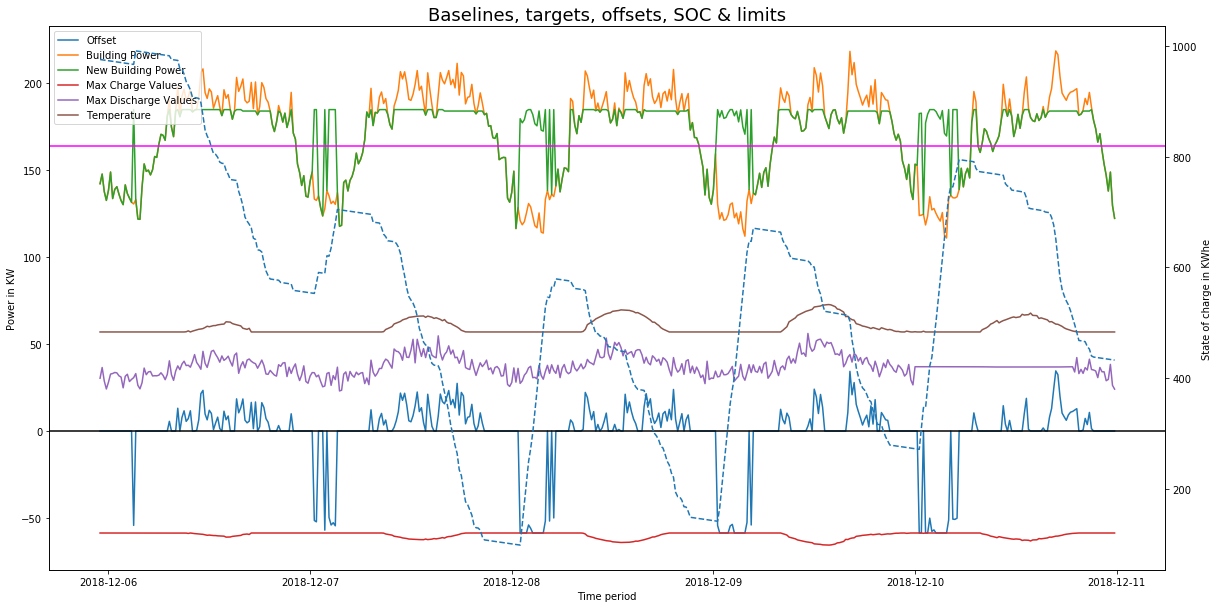

In [50]:
fig,ax = plt.subplots(figsize = (20,10))
plt.title(title, fontsize = 18)

#plotting power related graphs on first y axis
ln1 = ax.plot(output.Timestamps[476:960], output.Offset[476:960], label = "Offset");
ln2 = ax.plot(output.Timestamps[476:960], output.Baseline[476:960], label = 'Building Power');
ln3 = ax.plot(output.Timestamps[476:960], output.Target[476:960], label = 'New Building Power');
ln4 = ax.plot(output.Timestamps[476:960], output.Max_charge_limit[476:960], label = 'Max Charge Values');
ln5 = ax.plot(output.Timestamps[476:960], output.Max_discharge_limit[476:960], label = 'Max Discharge Values');
ln7 = ax.plot(output.Timestamps[476:960], output.Temperature[476:960], label = 'Temperature');

ax.set_xlabel('Time period')
ax.set_ylabel('Power in KW')

start, end = ax.get_xlim();
#ax.set_xticks(np.arange(start, end, 8))
#ax.set_xticklabels(sv)
#plt.xticks(np.arange(start+33.55, end+33.55, 16), sv, rotation=90);

#creating second y axis and plotting SOC
ax2 = ax.twinx();
ln6 = ax2.plot(output.Timestamps[476:960], output.State_of_charge[476:960], '--',label = "SOC");

ax2.set_ylabel('State of charge in KWhe')

ax.axhline(0, color = 'black');
ax.axhline(Cap_res, color = 'magenta');
#Managing labels and legend
lns = ln1 + ln2 + ln3 + ln4 + ln5 + ln7
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best');

In [51]:
Results = pd.DataFrame(columns = ["MCR","Tank_Capacity","Demand_savings","Energy_savings","Total_savings","RTE"])

/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


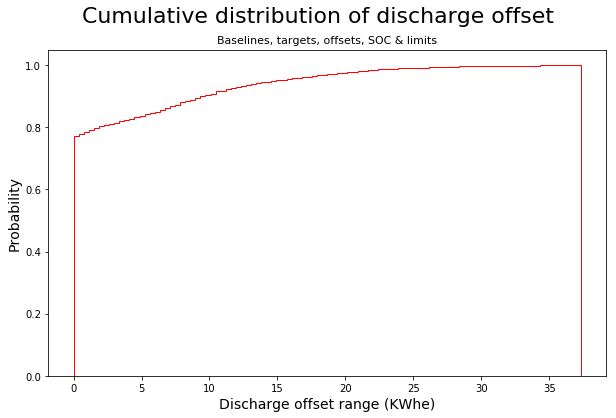

In [52]:
suptitle = "Cumulative distribution of discharge offset"
plt.figure(figsize = (10,6));
plt.suptitle(suptitle, fontsize = 22);
plt.title(title, fontsize = 11);
plt.hist(output.Discharge_offset, bins = 100, normed = True, cumulative = True, histtype = 'step', color = 'red');
plt.xlabel('Discharge offset range (KWhe)', fontsize = 14);
plt.ylabel('Probability',fontsize = 14);

In [53]:
Heat_loads = [a*b for a,b in zip(output.COP_discharge, output.Discharge_offset)]
normalized_SOC = [x/RB_capacity for x in output.State_of_charge]            

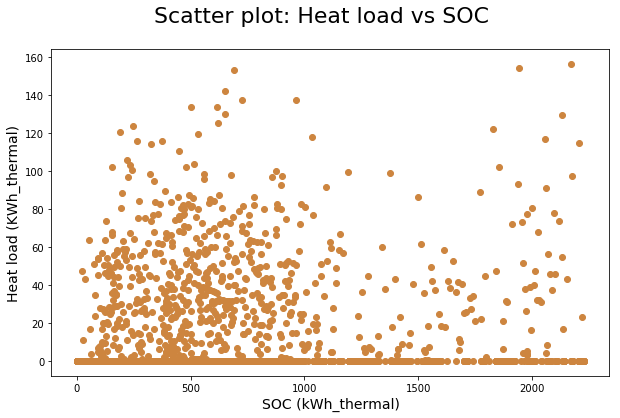

In [54]:
suptitle = "Scatter plot: Heat load vs SOC"
plt.figure(figsize = (10,6));
plt.suptitle(suptitle, fontsize = 22);
plt.scatter(output.State_of_charge, Heat_loads, color = 'peru');
plt.xlabel('SOC (kWh_thermal)', fontsize = 14);
plt.ylabel('Heat load (KWh_thermal)',fontsize = 14);

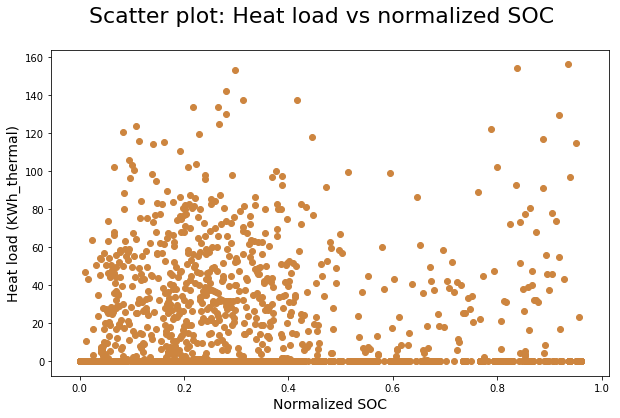

In [55]:
suptitle = "Scatter plot: Heat load vs normalized SOC"
plt.figure(figsize = (10,6));
plt.suptitle(suptitle, fontsize = 22);
plt.scatter(normalized_SOC,Heat_loads, color = 'peru');
plt.xlabel('Normalized SOC', fontsize = 14);
plt.ylabel('Heat load (KWh_thermal)',fontsize = 14);

# RTE:

In [56]:
rte = sum(output.Discharge_offset)/-sum(output.Charge_offset)

In [57]:
print("The RTE is %.2f" %(rte))

The RTE is 0.45


## Discharge & Charge kWth & kWhe

In [58]:
DCHG_kWhe = 0.25*output.Discharge_offset.sum()
CHG_kWhe = -0.25*output.Charge_offset.sum()

In [59]:
DCHG_kWhth = sum(0.25*output.Discharge_offset*output.COP_discharge)
CHG_kWhth = -sum(0.25*output.Charge_offset*output.COP_charge)

In [60]:
DCHG_kWhe

1715.2203017775

In [61]:
CHG_kWhe

3799.2793737500006

In [62]:
DCHG_kWhth

7025.461606389614

In [63]:
CHG_kWhth

8697.341516132137

# 